In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/meme_classification_data/'

#Data Loading and Cleaning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import nltk
from wordcloud import WordCloud
from tqdm import tqdm
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()
contractions = {
"ain't": "are not",
"aren't": "are not",
"can't": "can not",
"can't've": "can not have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_short_forms(word):
    if(word.lower() in contractions):
        return contractions[word.lower()]
    else:
        return word

expand_short_forms("isn't")

import re
def remove_special_chars_except_apostrophe(sentence):
    return re.sub(r"[^\w\d'\s]+",'',sentence.lower())

ps = PorterStemmer()


def clean_text_keep_stop_words(text):
    sent = re.sub(r"[^\w\d'\s]+",'',text.lower()) # remove special chars excecpt apostrophe
    words = sent.split() 
    base_words = [ps.stem(w) for w in words] # get stem words
    
    base_words_expanded = []
    for w in base_words:
        if w in contractions:
            base_words_expanded.append(contractions[w])
        else:
            base_words_expanded.append(w)
        
        sent = " ".join(base_words_expanded)
            
    return sent

filter_words = ["meme", "http", "www"]

def filter_words_after_cleaning(text):
    words = text.split()
    filtered_words = []
    for w in words:
        flg = 0
        for fw in filter_words:
            if fw in w:
                flg = 1
                break
            if 'com' in w and len(w) > 7:
                flg = 1
        
        if flg == 0:
            filtered_words.append(w)
        
    sent = " ".join(filtered_words)
    return sent

def clean_text(data):
    data['clean text'] = data['text'].apply(clean_text_keep_stop_words)
    data['clean text final'] = data['clean text'].apply(filter_words_after_cleaning)
    data.drop(['text', 'clean text'], axis = 1, inplace = True)
    data.rename(columns={'clean text final' : 'text'}, inplace = True)

train_data = pd.read_csv(PATH+'train.csv')
clean_text(train_data)
train_data.head(3)

,ID,image id,label,label_num,text
0,1,image_2455.jpg,troll,2,it is not our fight are we not part of thi wor...
1,2,image_3701.jpg,none,0,that' the differ between you and me you wanna ...
2,3,image_4166.png,none,0,what do the titan and the sixth sens have in c...


#Feature Extraction from scores of pre-trained BERT models
https://github.com/cardiffnlp/tweeteval

We extract emotion,hate,irony,offense and sentiment scores from these models.

In [ ]:
!pip install transformers
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [ ]:
def get_feats(df,task):
  print("Extracting Feats:", task)
  MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
  tokenizer = AutoTokenizer.from_pretrained(MODEL)
  # download label mapping
  mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
  with urllib.request.urlopen(mapping_link) as f:
      html = f.read().decode('utf-8').split("\n")
      csvreader = csv.reader(html, delimiter='\t')
  labels = [row[1] for row in csvreader if len(row) > 1]
  model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
  all_scores = [ [] for i in range(len(labels)) ]
  print("starting")
  for idx, row in df.iterrows():
    text = row['text']
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    for i in range(scores.shape[0]):
      l = labels[i]
      s = scores[i]
      all_scores[i].append(s)
    print("DONE", idx)
  for i in range(len(labels)):
    df[labels[i]] = all_scores[i]
  display(df.head(10))


In [ ]:
## Will take around 20 minutes to run
tasks = ['emotion', 'irony', 'hate', 'offensive', 'sentiment']
for task in tasks:
  get_feats(train_data,task)

In [ ]:
train_data.to_csv('/content/drive/MyDrive/meme_classification_data/train_with_tweetevel_feats.csv', index=False)


In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/meme_classification_data/train_with_tweetevel_feats.csv')
train_data.head(3)

,ID,image id,label,label_num,text,anger,joy,optimism,sadness,non_irony,irony,not-hate,hate,not-offensive,offensive,negative,neutral,positive
0,1,image_2455.jpg,troll,2,it is not our fight are we not part of thi wor...,0.675407,0.009434,0.240503,0.074657,0.965689,0.034311,0.974778,0.025222,0.892819,0.107181,0.495678,0.478910,0.025411
1,2,image_3701.jpg,none,0,that' the differ between you and me you wanna ...,0.660467,0.047432,0.152295,0.139805,0.956159,0.043841,0.942887,0.057113,0.819430,0.180570,0.174729,0.692347,0.132924
2,3,image_4166.png,none,0,what do the titan and the sixth sens have in c...,0.376536,0.104580,0.037110,0.481774,0.922924,0.077075,0.963018,0.036982,0.762072,0.237928,0.148650,0.826134,0.025215


In [ ]:
train_labels = train_data['label_num'].values 
train_data.drop(columns=['ID','image id', 'label_num','label','text'],inplace=True)
train_ftrs = train_data.values
train_labels_one_hot = np.zeros((train_labels.size, train_labels.max()+1))
train_labels_one_hot[np.arange(train_labels.size), train_labels] = 1
train_labels_one_hot

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_ftrs,train_labels_one_hot,test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1592, 13) (399, 13) (1592, 3) (399, 3)


#Models

##Neural Network

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=60, batch_size=64)

Epoch 1/60
25/25 [==============================] - 1s 3ms/step - loss: 1.1115 - accuracy: 0.3235
Epoch 2/60
25/25 [==============================] - 0s 3ms/step - loss: 1.0948 - accuracy: 0.3503
Epoch 3/60
25/25 [==============================] - 0s 2ms/step - loss: 1.0945 - accuracy: 0.3771
Epoch 4/60
25/25 [==============================] - 0s 2ms/step - loss: 1.0937 - accuracy: 0.3742
Epoch 5/60
25/25 [==============================] - 0s 2ms/step - loss: 1.0926 - accuracy: 0.4015
Epoch 6/60
25/25 [==============================] - 0s 2ms/step - loss: 1.0902 - accuracy: 0.3795
Epoch 7/60
25/25 [==============================] - 0s 2ms/step - loss: 1.0881 - accuracy: 0.3808
Epoch 8/60
25/25 [==============================] - 0s 2ms/step - loss: 1.0898 - accuracy: 0.3645
Epoch 9/60
25/25 [==============================] - 0s 2ms/step - loss: 1.0880 - accuracy: 0.3743
Epoch 10/60
25/25 [==============================] - 0s 2ms/step - loss: 1.0885 - accuracy: 0.3993
Epoch 11/60
25/25 [

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(y_pred.shape, y_true.shape)
print(classification_report(y_true,y_pred))



(399,) (399,)
              precision    recall  f1-score   support

           0       0.35      0.26      0.30       117
           1       0.36      0.36      0.36       136
           2       0.40      0.49      0.44       146

    accuracy                           0.38       399
   macro avg       0.37      0.37      0.37       399
weighted avg       0.37      0.38      0.37       399



##SVM

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_ftrs,train_labels,test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(1592, 13) (399, 13) (1592,) (399,)


In [ ]:
from sklearn.svm import SVC
#model = SVC(kernel = 'rbf')
#model = SVC(kernel = 'poly', degree=10)
#model = SVC(kernel = 'linear')
model = SVC(kernel = 'poly', degree=8)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.36      0.35      0.35       117
           1       0.39      0.40      0.40       136
           2       0.39      0.38      0.38       146

    accuracy                           0.38       399
   macro avg       0.38      0.38      0.38       399
weighted avg       0.38      0.38      0.38       399



##XGB Classifier

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_ftrs,train_labels,test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1592, 13) (399, 13) (1592,) (399,)


In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.34      0.22      0.27       117
           1       0.38      0.50      0.43       136
           2       0.43      0.42      0.43       146

    accuracy                           0.39       399
   macro avg       0.38      0.38      0.38       399
weighted avg       0.39      0.39      0.38       399



#Analysis of features

In [ ]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /usr/local/lib/python3.7/dist-packages (0.11.1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

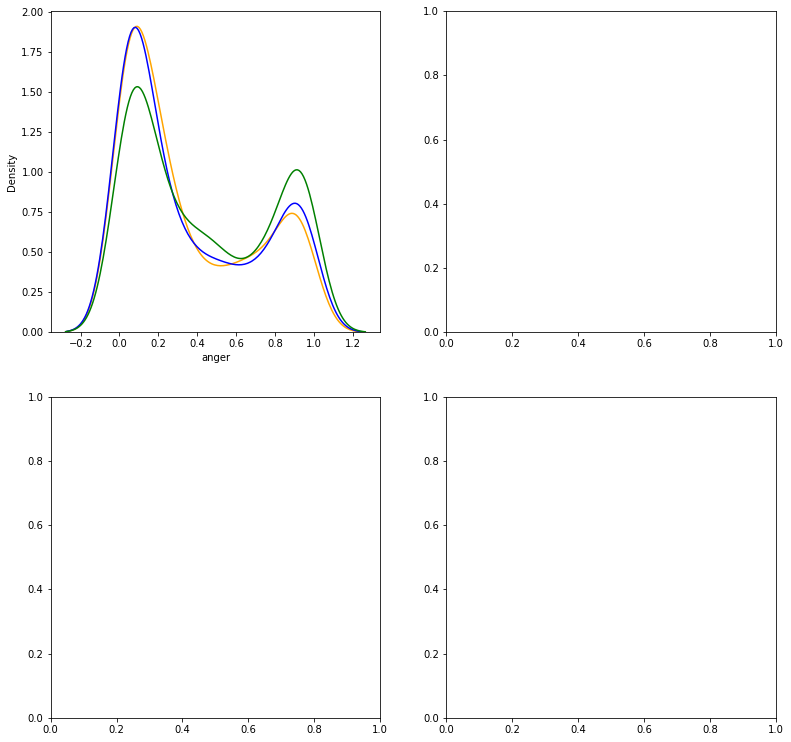

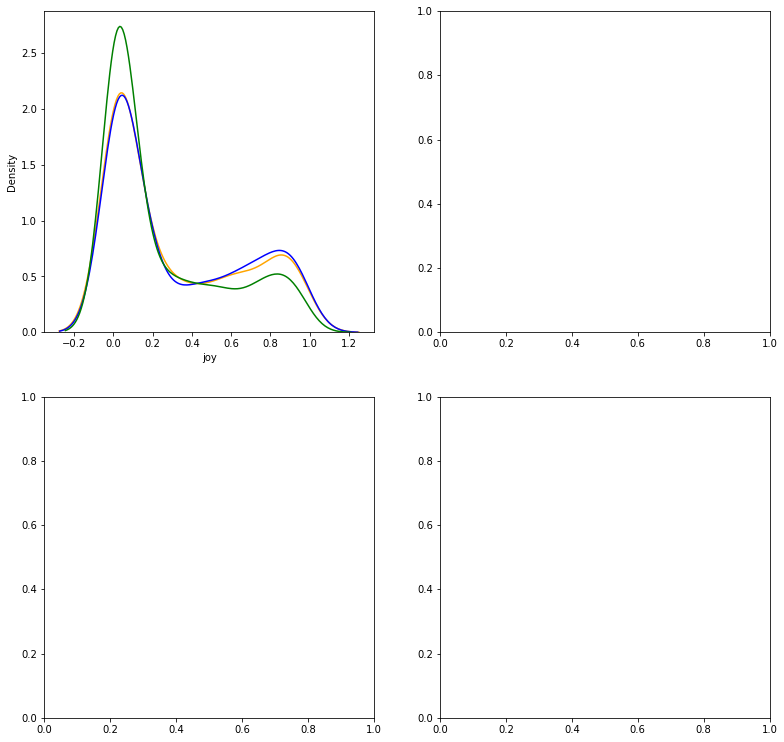

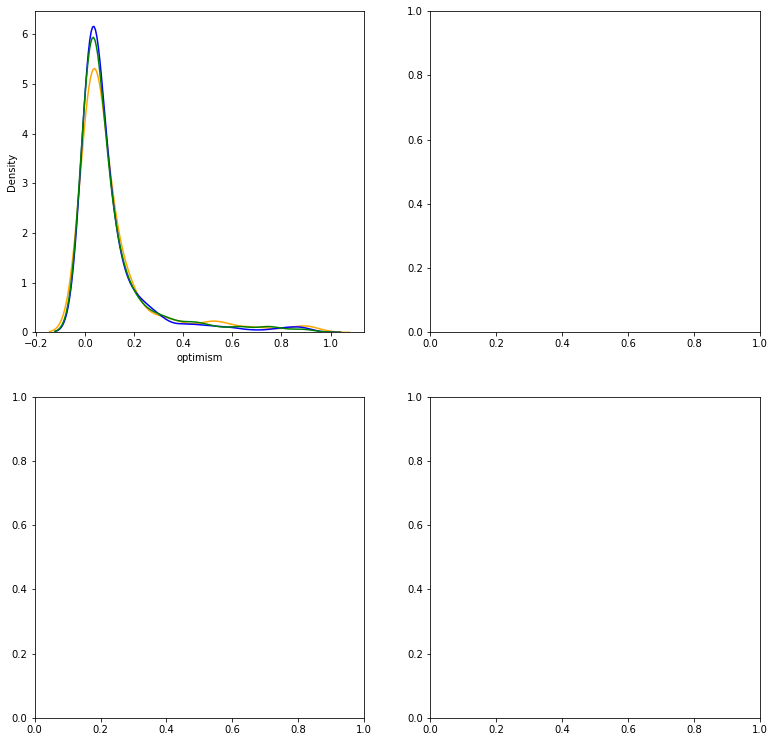

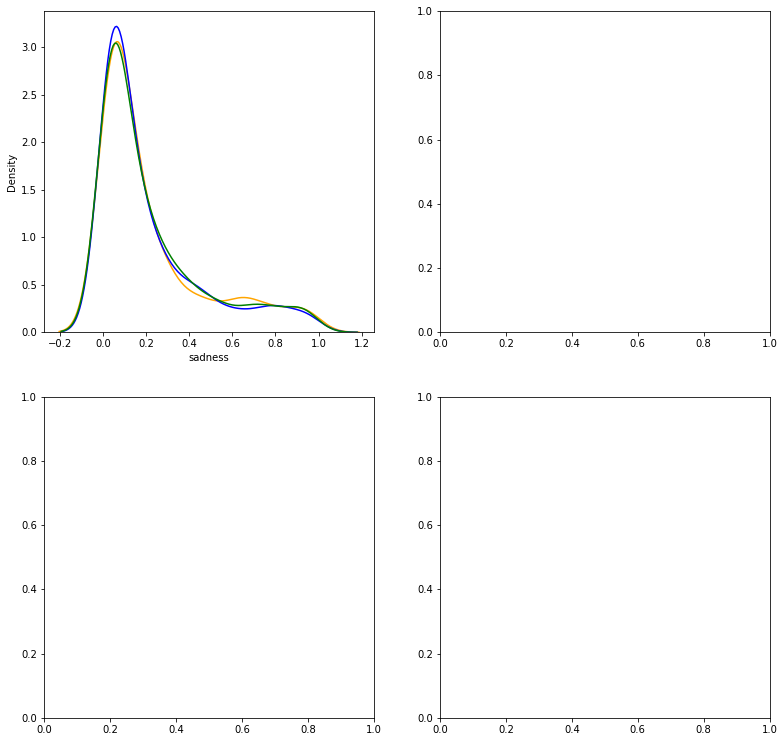

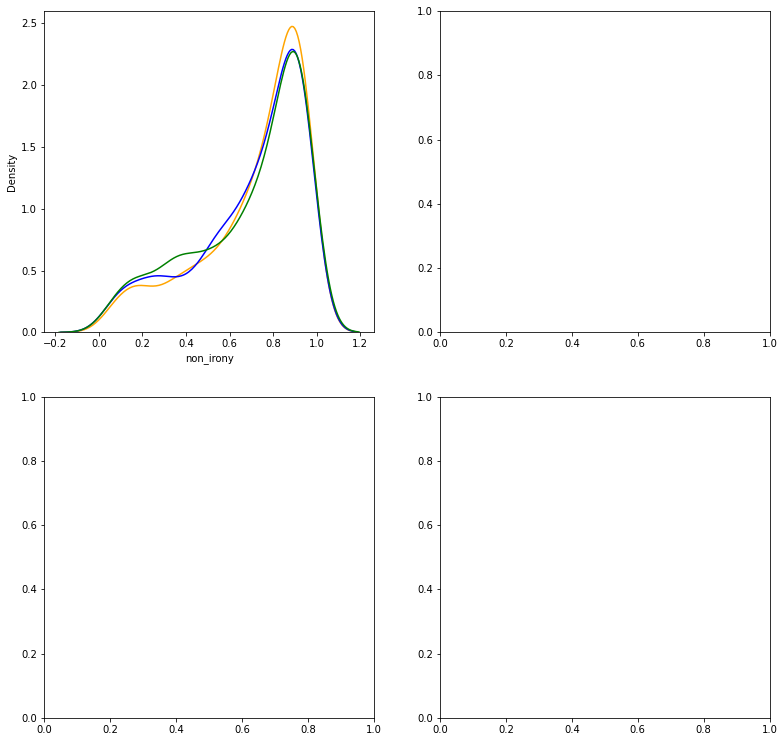

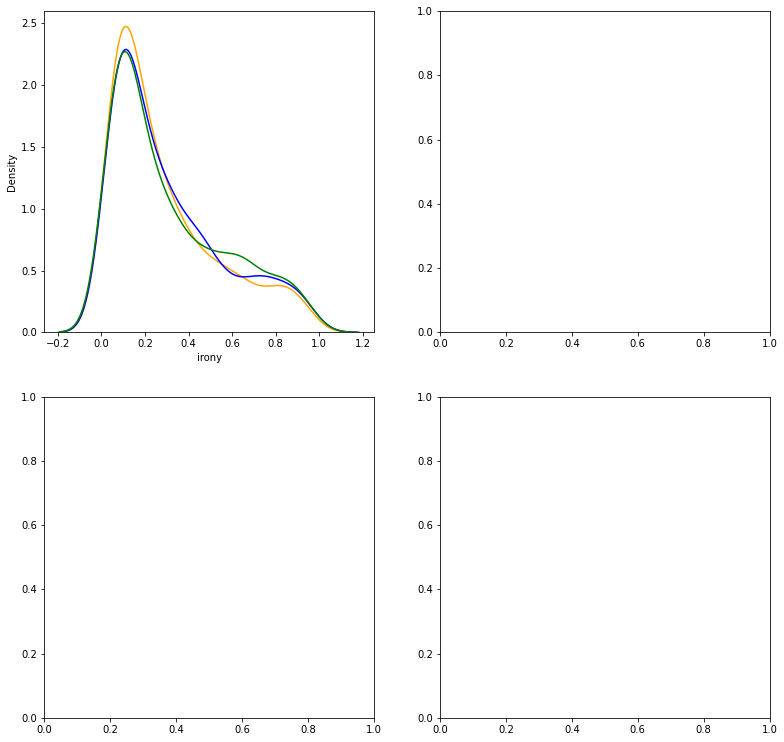

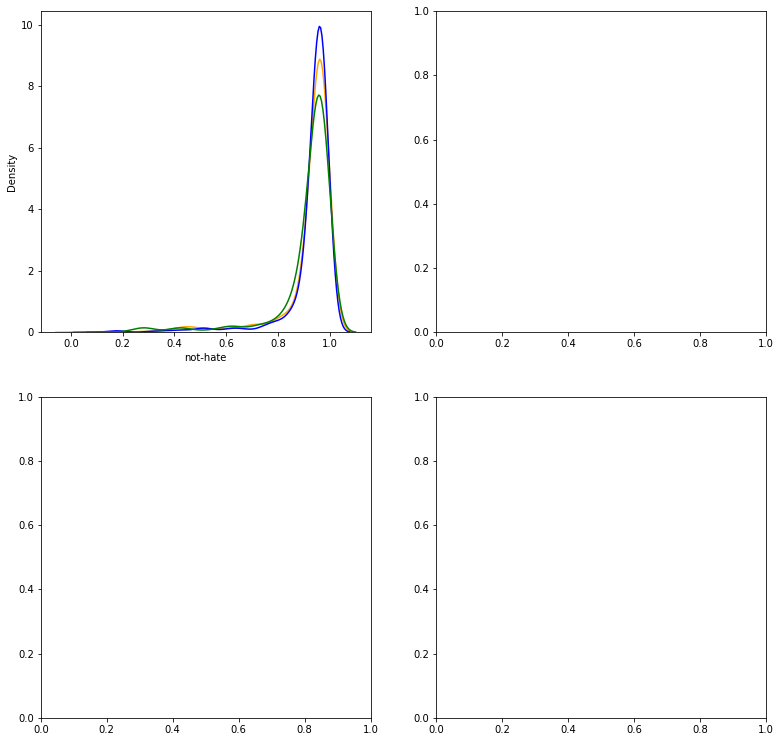

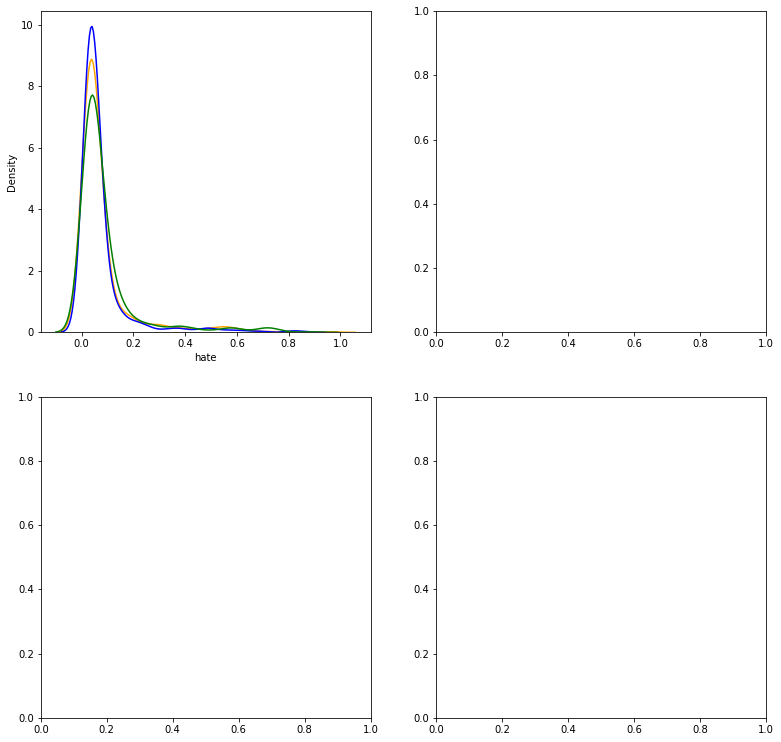

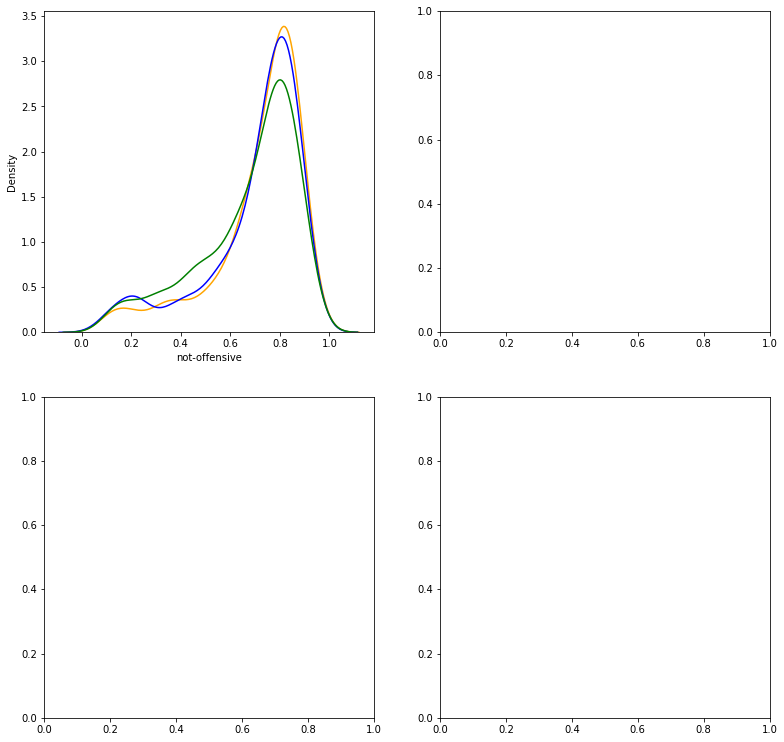

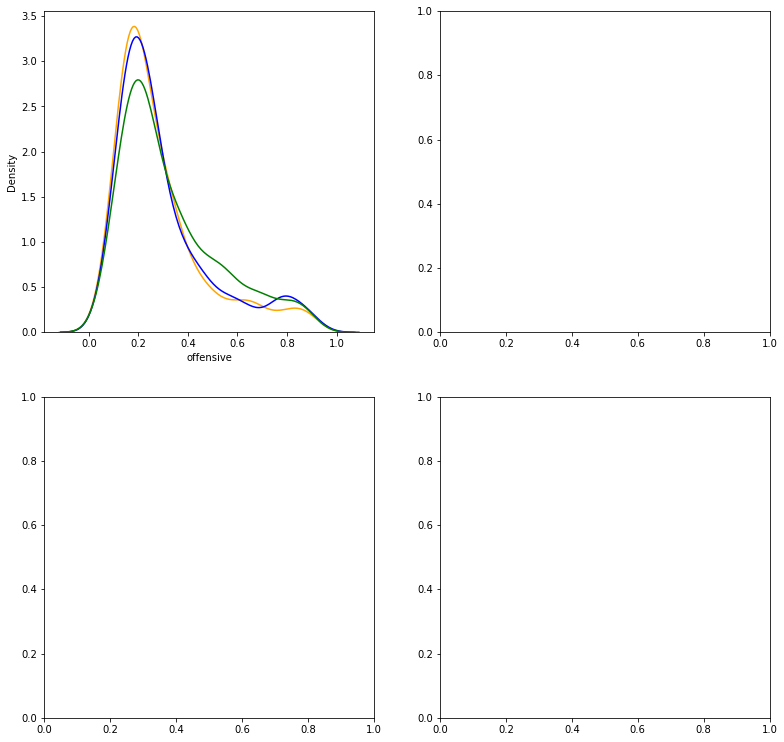

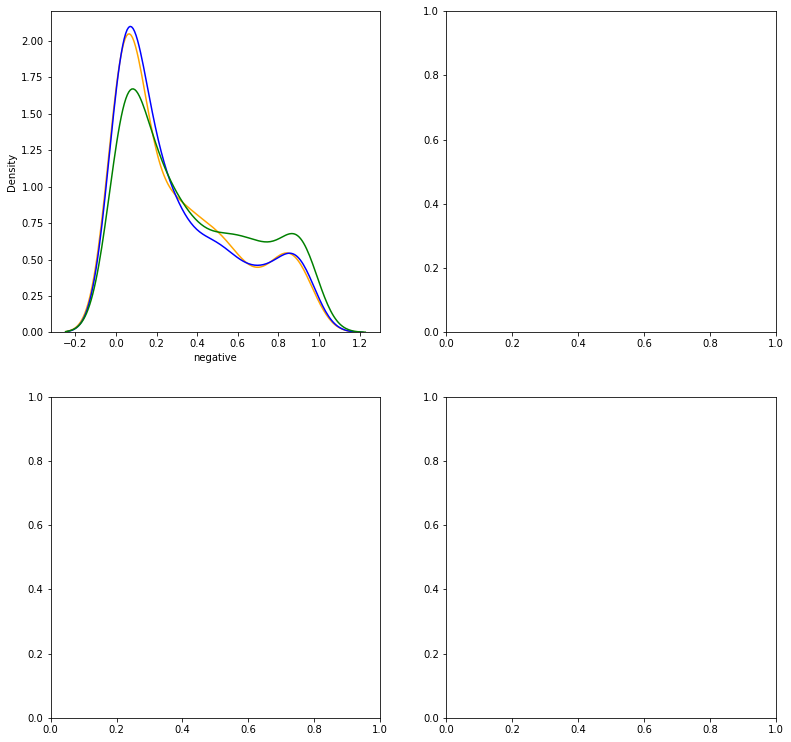

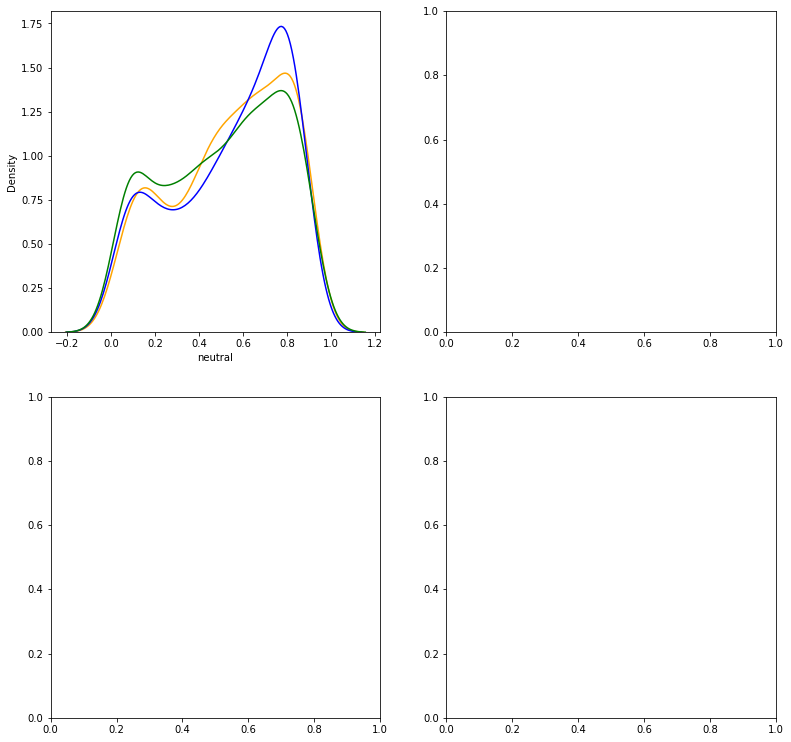

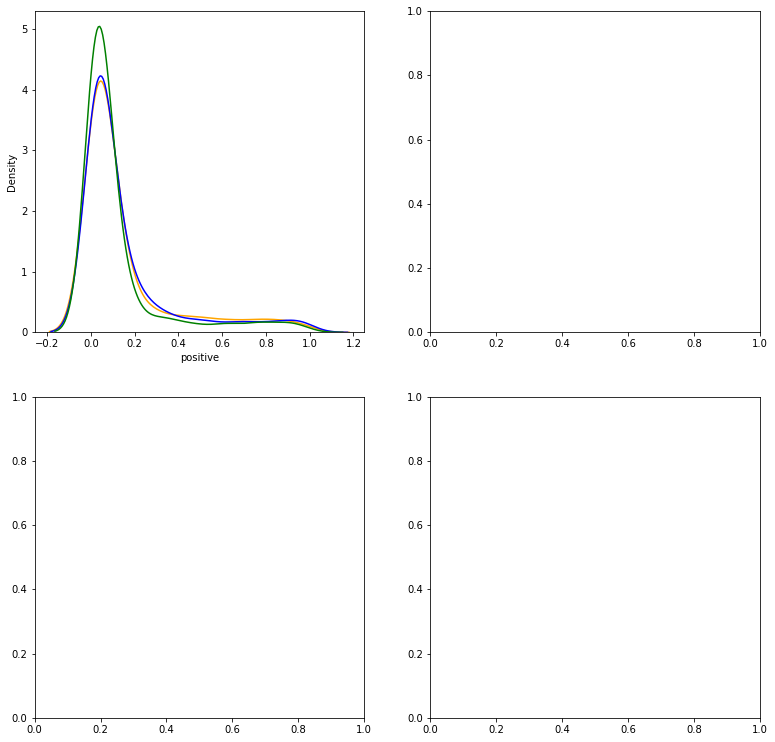

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df_train = pd.read_csv('/content/drive/MyDrive/meme_classification_data/train_with_tweetevel_feats.csv')
all_labels = df_train.columns[5:]
for label in all_labels:
  #fig,ax=plt.subplots(nrows=1,ncols=1) # Error??
  fig,ax=plt.subplots(nrows=2,ncols=2)
  fig.set_figheight(13)
  fig.set_figwidth(13)
  h=df_train[label]
  sns.distplot(h[df_train['label_num']==0],ax=ax[0,0],hist = False, kde = True,label = 'None',color = 'orange')
  sns.distplot(h[df_train['label_num']==1],ax=ax[0,0],hist = False, kde = True,label = 'Funny', color = 'blue')
  sns.distplot(h[df_train['label_num']==2],ax=ax[0,0],hist = False, kde = True,label = 'Troll', color = 'green')

# none = orange,
# hilarious = blue,
# troll = green


none = orange,
funny = blue,
troll = green
